First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# for function later

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
yList= np.column_stack((burn_label,un_label,duration_label))# y list is a 2D array, each column is a response outcome

In [6]:
print(yList[:5])
      
for i in range(yList.shape[1]):
    print(pd.Series(yList[:,i]).value_counts())

[['No' 'Natural' 'Annual']
 ['No' 'Natural' 'Perennial']
 ['No' 'Urban' 'Perennial']
 ['No' 'Urban' 'Annual']
 ['No' 'Urban' 'Perennial']]
Yes    42
No     17
Name: count, dtype: int64
Urban      33
Natural    26
Name: count, dtype: int64
Perennial    37
Annual       22
Name: count, dtype: int64


In [7]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

In [8]:
selection_result = FS.SelectMicro_multi_fun(df,yList)

In [9]:
print(selection_result['H_score'])
selectedOTU_index = selection_result['selected_indices']
data = selection_result['relative_abundance_data']
X_FS = selection_result['selected_data']

print(np.shape(data),np.shape(X_FS))

[[3.58783345 4.62436719 5.89262923 ... 0.         0.         0.        ]
 [2.4157006  1.16409551 2.79448091 ... 0.         0.         0.        ]
 [0.1986735  0.57734704 3.25951225 ... 0.         0.         0.        ]]
(59, 1768) (59, 86)


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [10]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [11]:
X_lasso_list = []
X_lassoft_list =[]
selectedOTU_index_lasso_list = []
selectedOTU_index_lassoft_list = []

In [12]:
for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())
    # obtain the lasso selected data and variable indices
    X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
    X_lasso_list.append(X_lasso)
    selectedOTU_index_lasso_list.append(xlabel_lasso)
    # obtain the fine tuned lasso selected data and variable indices
    X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lassoft_list.append(X_lasso_ft)
    selectedOTU_index_lassoft_list.append(xlabel_lasso_ft)

    print(f'The shape of the Lasso selected dataset is ',np.shape(X_lasso))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
    

The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.1
The shape of the Lasso selected dataset is  (59, 21)
The shape of the Lasso_finetune selected dataset is  (59, 14)
The response variable and its counts are:
Urban      33
Natural    26
Name: count, dtype: int64
Best alpha: 0.1
The shape of the Lasso selected dataset is  (59, 58)
The shape of the Lasso_finetune selected dataset is  (59, 11)
The response variable and its counts are:
Perennial    37
Annual       22
Name: count, dtype: int64
Best alpha: 0.1
The shape of the Lasso selected dataset is  (59, 47)
The shape of the Lasso_finetune selected dataset is  (59, 7)


In [13]:
for i in range(yList.shape[1]):
    data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso_list[i],
                "Lasso_finetune":X_lassoft_list[i],
               #"Random":data
              }
    print(f"The response variable and its counts are: {pd.Series(yList[:,i]).value_counts()}")
    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= yList[:,i],N=iter,classifiers=cls,SMOTE=True)
    print(metric.metric_sum(dict_cm))
    
    

The response variable and its counts are: Yes    42
No     17
Name: count, dtype: int64
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>


TBB Warning: The number of workers is currently limited to 0. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <clas

In [14]:
for i in range(3):
    targetLabel = yList[:,i]
    data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso_list[i],
                "Lasso_finetune":X_lassoft_list[i],
               #"Random":data
              }
    for datatype, subset in data_subset.items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")


f1 of AllFeatures = 0.036093571621673065
f1 of SelectMicro = 0.05872588532726406
f1 of Lasso = 0.13237641472701353
f1 of Lasso_finetune = 0.15251671332794658
f1 of AllFeatures = 0.016829372994488615
f1 of SelectMicro = 0.018464749239405304
f1 of Lasso = 0.03015602869412207
f1 of Lasso_finetune = 0.0642447586197016
f1 of AllFeatures = 0.018576225758383434
f1 of SelectMicro = 0.023054557793308835
f1 of Lasso = 0.03544814127455362
f1 of Lasso_finetune = 0.08887784057465911


## compare the first 20 index

{'No', 'Yes'}
SelectMicro for burn
Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
       OTU  presence_pos  presence_neg
0    ASV81      0.000000      0.294118
1   ASV148      0.000000      0.294118
2    ASV66      0.000000      0.294118
3    ASV85      0.000000      0.294118
4    ASV73      0.023810      0.294118
5   ASV141      0.000000      0.294118
6    ASV38      0.047619      0.352941
7    ASV26      0.190476      0.000000
8    ASV15      0.190476      0.000000
9     ASV3      0.285714      0.000000
10   ASV18      0.238095      0.000000
11   ASV43      0.000000      0.235294
12   ASV72      0.142857      0.000000
13  ASV111      0.142857      0.000000
14  ASV181      0.000000      0.176471


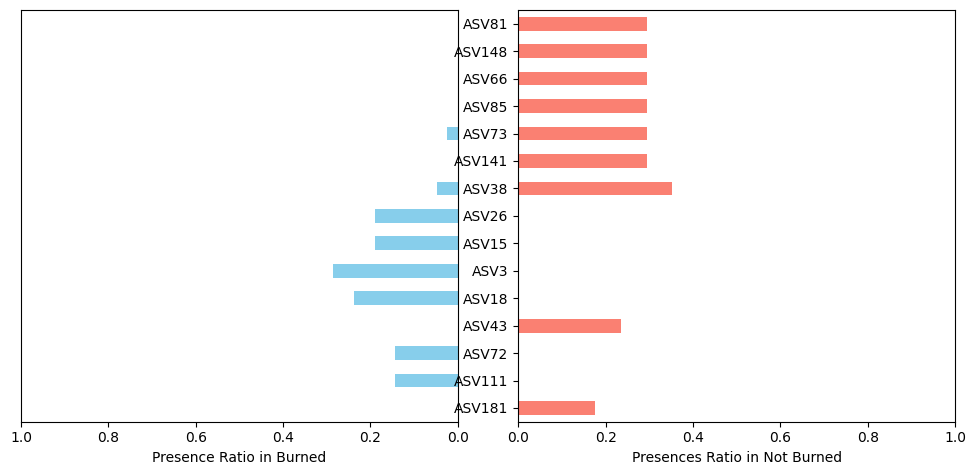

Lasso_ft for burn
Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
       OTU  presence_pos  presence_neg
0     ASV7      0.452381      0.117647
1     ASV8      0.119048      0.294118
2    ASV81      0.000000      0.294118
3    ASV85      0.000000      0.294118
4    ASV94      0.023810      0.235294
5   ASV141      0.000000      0.294118
6   ASV146      0.000000      0.117647
7   ASV148      0.000000      0.294118
8   ASV208      0.000000      0.176471
9   ASV216      0.000000      0.176471
10  ASV225      0.000000      0.117647
11  ASV315      0.000000      0.117647
12  ASV335      0.000000      0.117647
13  ASV338      0.000000      0.117647


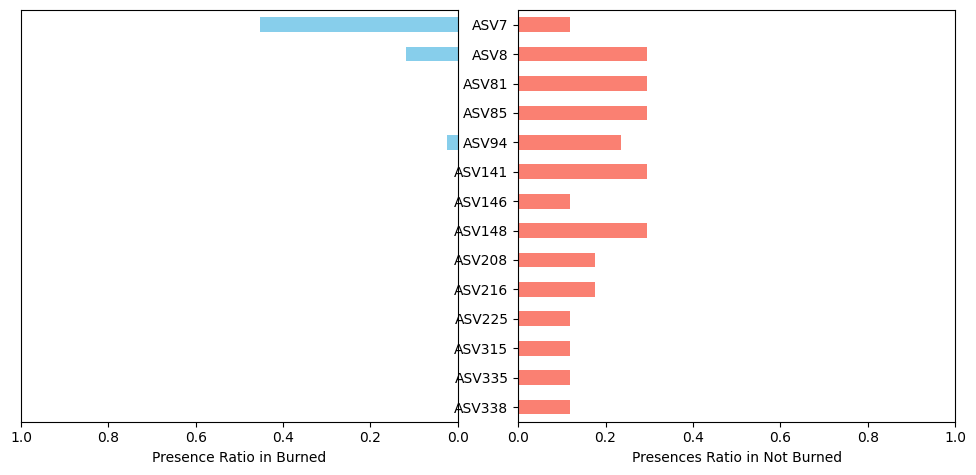

{'Natural', 'Urban'}
SelectMicro for urban
Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
       OTU  presence_pos  presence_neg
0    ASV81      0.000000      0.151515
1   ASV148      0.000000      0.151515
2    ASV66      0.038462      0.121212
3    ASV85      0.076923      0.090909
4    ASV73      0.000000      0.181818
5   ASV141      0.076923      0.090909
6    ASV38      0.038462      0.212121
7    ASV26      0.269231      0.030303
8    ASV15      0.230769      0.060606
9     ASV3      0.307692      0.121212
10   ASV18      0.307692      0.060606
11   ASV43      0.038462      0.090909
12   ASV72      0.230769      0.000000
13  ASV111      0.230769      0.000000
14  ASV181      0.000000      0.090909


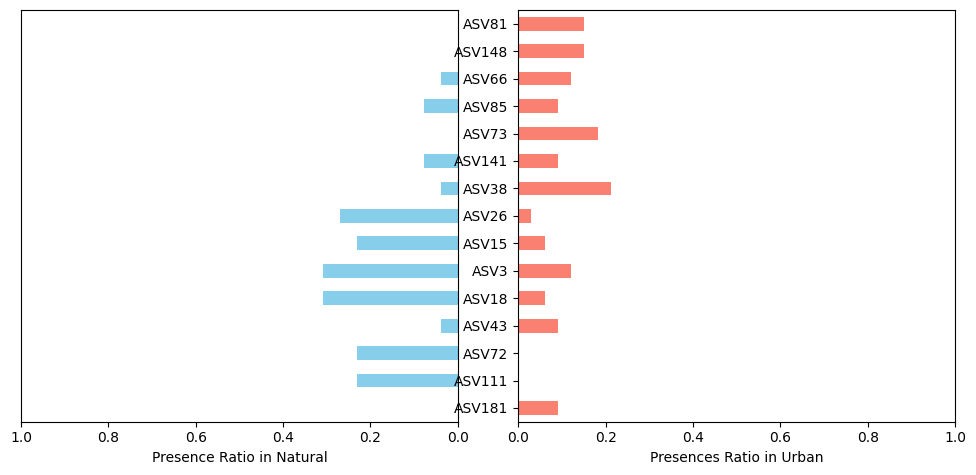

Lasso_ft for urban
Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
       OTU  presence_pos  presence_neg
0    ASV18      0.307692      0.060606
1    ASV52      0.000000      0.151515
2    ASV76      0.115385      0.060606
3    ASV79      0.000000      0.212121
4    ASV81      0.000000      0.151515
5    ASV95      0.192308      0.030303
6   ASV111      0.230769      0.000000
7   ASV114      0.000000      0.121212
8   ASV138      0.115385      0.000000
9   ASV179      0.115385      0.000000
10  ASV225      0.076923      0.000000


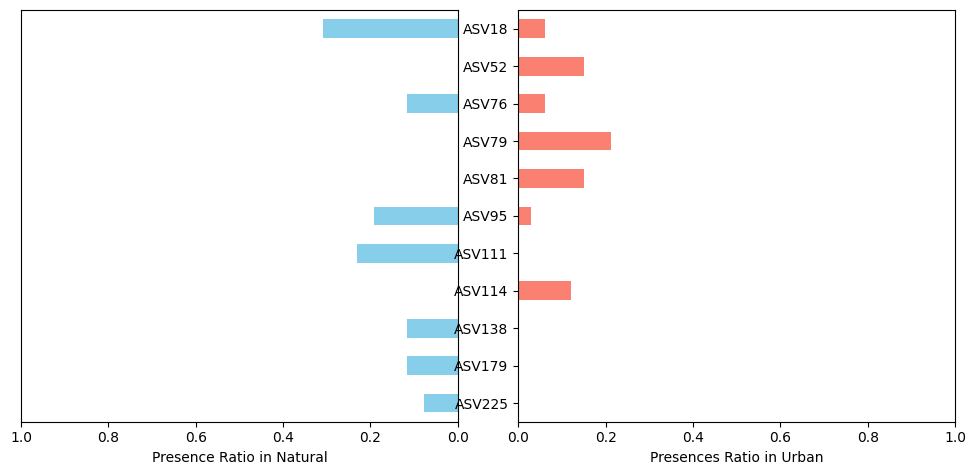

{'Annual', 'Perennial'}
SelectMicro for Natual
Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
       OTU  presence_pos  presence_neg
0    ASV81      0.045455      0.108108
1   ASV148      0.045455      0.108108
2    ASV66      0.000000      0.135135
3    ASV85      0.000000      0.135135
4    ASV73      0.090909      0.108108
5   ASV141      0.045455      0.108108
6    ASV38      0.090909      0.162162
7    ASV26      0.227273      0.081081
8    ASV15      0.272727      0.054054
9     ASV3      0.318182      0.135135
10   ASV18      0.227273      0.135135
11   ASV43      0.090909      0.054054
12   ASV72      0.090909      0.108108
13  ASV111      0.090909      0.108108
14  ASV181      0.045455      0.054054


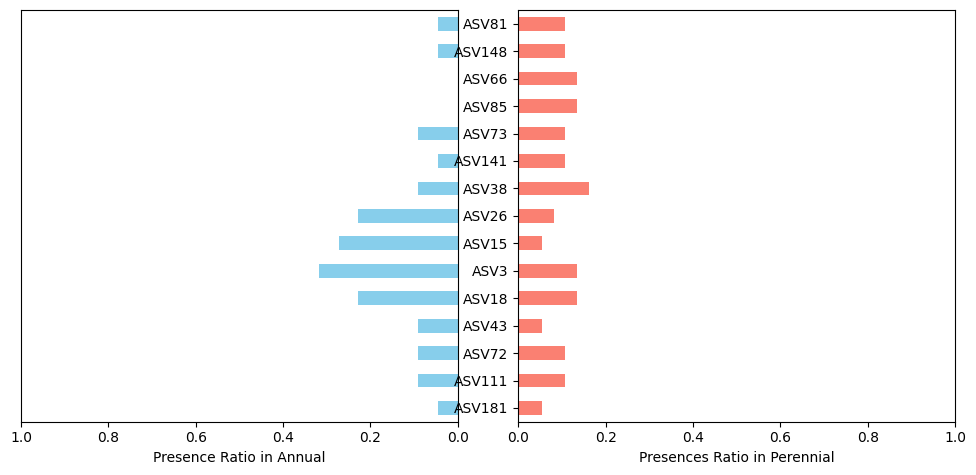

Lasso_ft for Natual
Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
      OTU  presence_pos  presence_neg
0   ASV15      0.272727      0.054054
1   ASV61      0.181818      0.027027
2  ASV250      0.090909      0.000000
3  ASV270      0.090909      0.000000
4  ASV271      0.090909      0.000000
5  ASV276      0.090909      0.000000
6  ASV310      0.136364      0.000000


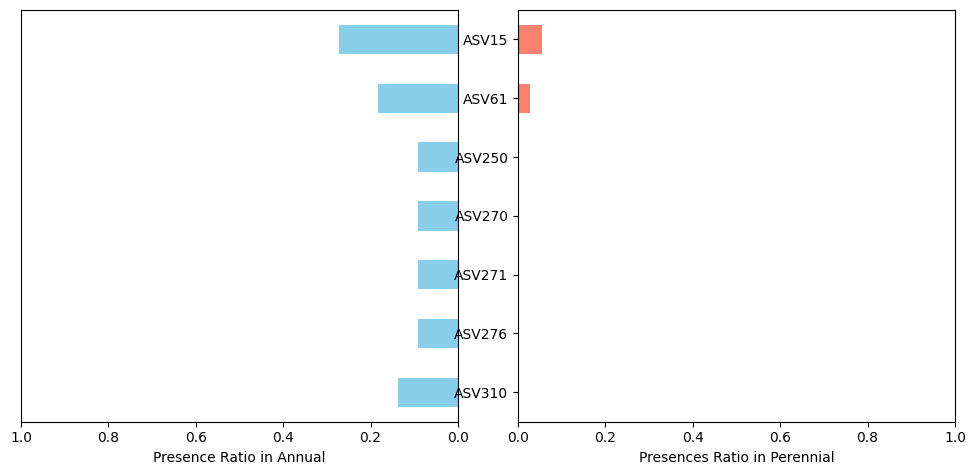

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements


entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
selectedASVs_15=ASVs[selectedOTU_index_15]

X_FS_15=data[:,selectedOTU_index_15]

targetLabel=burn_label
print(set(targetLabel))
print("SelectMicro for burn")
FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="Yes",posText="Burned",negText="Not Burned")
print("Lasso_ft for burn")
FS.plotPresenseRatio(X_lassoft_list[0],targetLabel,ASVs[selectedOTU_index_lassoft_list[0]],posLabel="Yes",posText="Burned",negText="Not Burned")

targetLabel=un_label
print(set(targetLabel))
print("SelectMicro for urban")
FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="Natural",posText="Natural",negText="Urban")
print("Lasso_ft for urban")
FS.plotPresenseRatio(X_lassoft_list[1],targetLabel,ASVs[selectedOTU_index_lassoft_list[1]],posLabel="Natural",posText="Natural",negText="Urban")


targetLabel=duration_label
print(set(targetLabel))

print("SelectMicro for Natual")
FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="Annual",posText="Annual",negText="Perennial")

print("Lasso_ft for Natual")
FS.plotPresenseRatio(X_lassoft_list[2],targetLabel,ASVs[selectedOTU_index_lassoft_list[2]],posLabel="Annual",posText="Annual",negText="Perennial")




{'No', 'Yes'}
SelectMicro for burn
Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
       OTU  presence_pos  presence_neg
0    ASV81      0.000000      0.294118
1   ASV148      0.000000      0.294118
2    ASV66      0.000000      0.294118
3    ASV85      0.000000      0.294118
4    ASV73      0.023810      0.294118
5   ASV141      0.000000      0.294118
6    ASV38      0.047619      0.352941
7    ASV26      0.190476      0.000000
8    ASV15      0.190476      0.000000
9     ASV3      0.285714      0.000000
10   ASV18      0.238095      0.000000
11   ASV43      0.000000      0.235294
12   ASV72      0.142857      0.000000
13  ASV111      0.142857      0.000000
14  ASV181      0.000000      0.176471


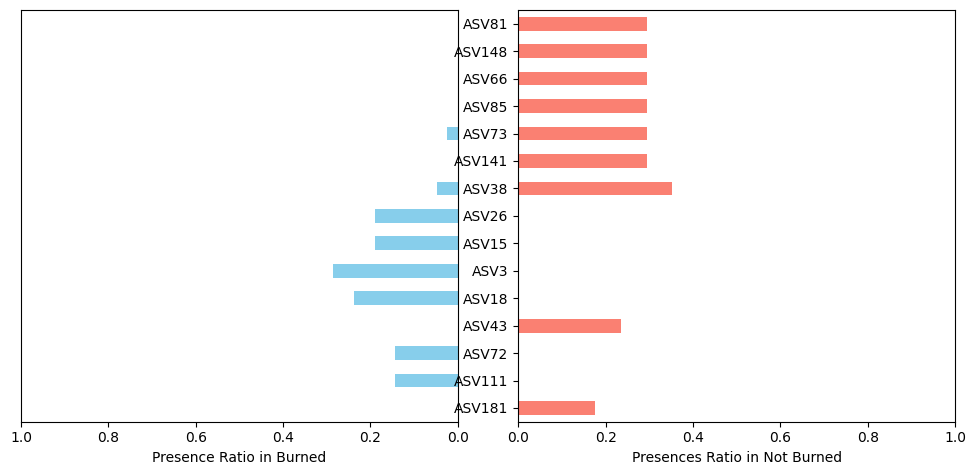

Lasso_ft for burn
Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
       OTU  presence_pos  presence_neg
0     ASV7      0.452381      0.117647
1     ASV8      0.119048      0.294118
2    ASV81      0.000000      0.294118
3    ASV85      0.000000      0.294118
4    ASV94      0.023810      0.235294
5   ASV141      0.000000      0.294118
6   ASV146      0.000000      0.117647
7   ASV148      0.000000      0.294118
8   ASV208      0.000000      0.176471
9   ASV216      0.000000      0.176471
10  ASV225      0.000000      0.117647
11  ASV315      0.000000      0.117647
12  ASV335      0.000000      0.117647
13  ASV338      0.000000      0.117647


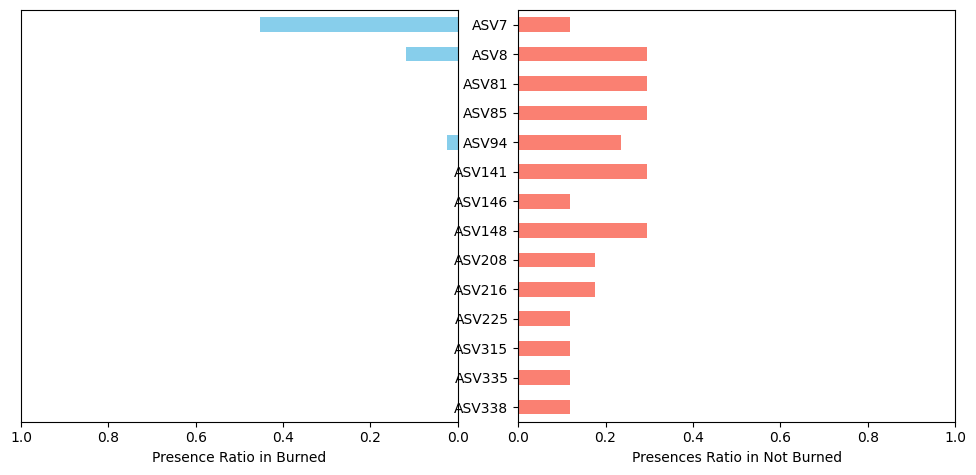

{'Natural', 'Urban'}
SelectMicro for urban
Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
       OTU  presence_pos  presence_neg
0    ASV81      0.000000      0.151515
1   ASV148      0.000000      0.151515
2    ASV66      0.038462      0.121212
3    ASV85      0.076923      0.090909
4    ASV73      0.000000      0.181818
5   ASV141      0.076923      0.090909
6    ASV38      0.038462      0.212121
7    ASV26      0.269231      0.030303
8    ASV15      0.230769      0.060606
9     ASV3      0.307692      0.121212
10   ASV18      0.307692      0.060606
11   ASV43      0.038462      0.090909
12   ASV72      0.230769      0.000000
13  ASV111      0.230769      0.000000
14  ASV181      0.000000      0.090909


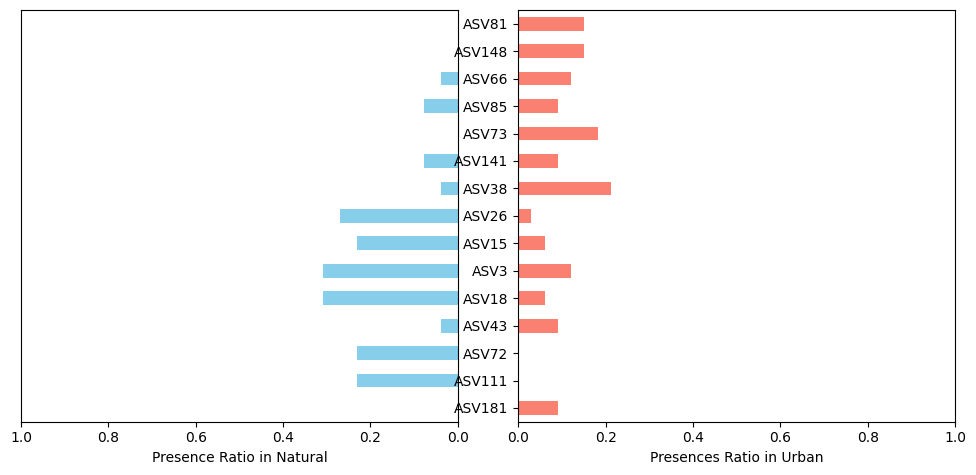

Lasso_ft for urban
Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
       OTU  presence_pos  presence_neg
0    ASV18      0.307692      0.060606
1    ASV52      0.000000      0.151515
2    ASV76      0.115385      0.060606
3    ASV79      0.000000      0.212121
4    ASV81      0.000000      0.151515
5    ASV95      0.192308      0.030303
6   ASV111      0.230769      0.000000
7   ASV114      0.000000      0.121212
8   ASV138      0.115385      0.000000
9   ASV179      0.115385      0.000000
10  ASV225      0.076923      0.000000


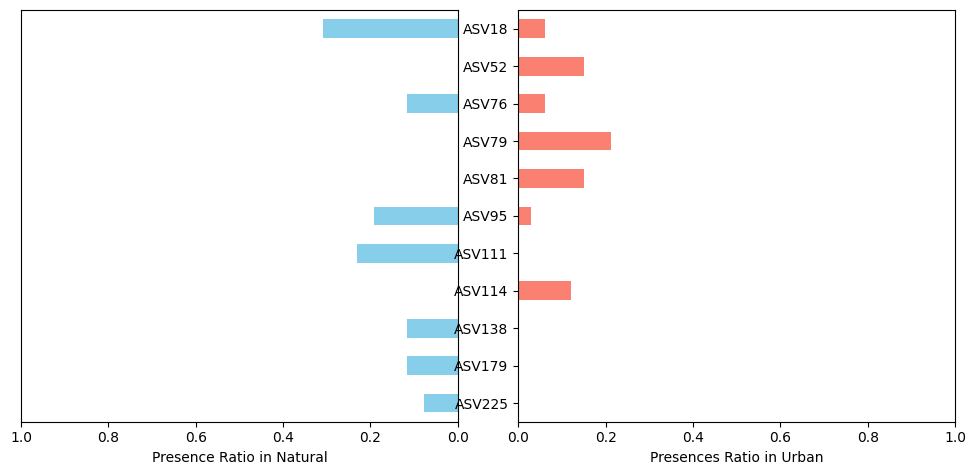

{'Annual', 'Perennial'}
SelectMicro for Natual
Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
       OTU  presence_pos  presence_neg
0    ASV81      0.045455      0.108108
1   ASV148      0.045455      0.108108
2    ASV66      0.000000      0.135135
3    ASV85      0.000000      0.135135
4    ASV73      0.090909      0.108108
5   ASV141      0.045455      0.108108
6    ASV38      0.090909      0.162162
7    ASV26      0.227273      0.081081
8    ASV15      0.272727      0.054054
9     ASV3      0.318182      0.135135
10   ASV18      0.227273      0.135135
11   ASV43      0.090909      0.054054
12   ASV72      0.090909      0.108108
13  ASV111      0.090909      0.108108
14  ASV181      0.045455      0.054054


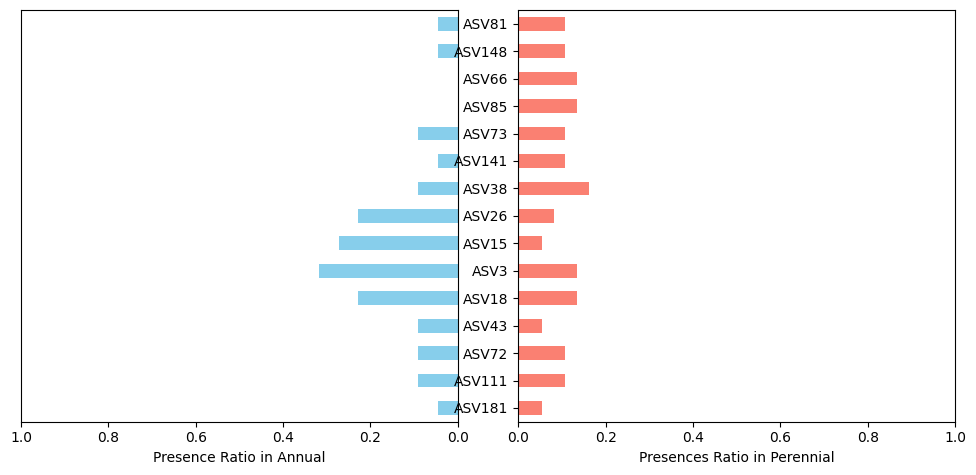

Lasso_ft for Natual
Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
      OTU  presence_pos  presence_neg
0   ASV15      0.272727      0.054054
1   ASV61      0.181818      0.027027
2  ASV250      0.090909      0.000000
3  ASV270      0.090909      0.000000
4  ASV271      0.090909      0.000000
5  ASV276      0.090909      0.000000
6  ASV310      0.136364      0.000000


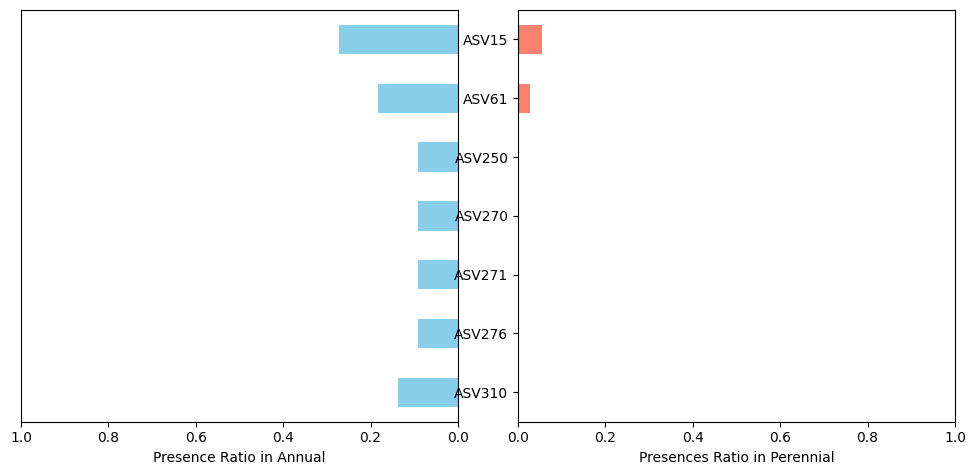

In [16]:
targetLabel=burn_label
print(set(targetLabel))
print("SelectMicro for burn")
FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="Yes",posText="Burned",negText="Not Burned")
print("Lasso_ft for burn")
FS.plotPresenseRatio(X_lassoft_list[0],targetLabel,ASVs[selectedOTU_index_lassoft_list[0]],posLabel="Yes",posText="Burned",negText="Not Burned")

targetLabel=un_label
print(set(targetLabel))
print("SelectMicro for urban")
FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="Natural",posText="Natural",negText="Urban")
print("Lasso_ft for urban")
FS.plotPresenseRatio(X_lassoft_list[1],targetLabel,ASVs[selectedOTU_index_lassoft_list[1]],posLabel="Natural",posText="Natural",negText="Urban")


targetLabel=duration_label
print(set(targetLabel))

print("SelectMicro for Natual")
FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="Annual",posText="Annual",negText="Perennial")

print("Lasso_ft for Natual")
FS.plotPresenseRatio(X_lassoft_list[2],targetLabel,ASVs[selectedOTU_index_lassoft_list[2]],posLabel="Annual",posText="Annual",negText="Perennial")




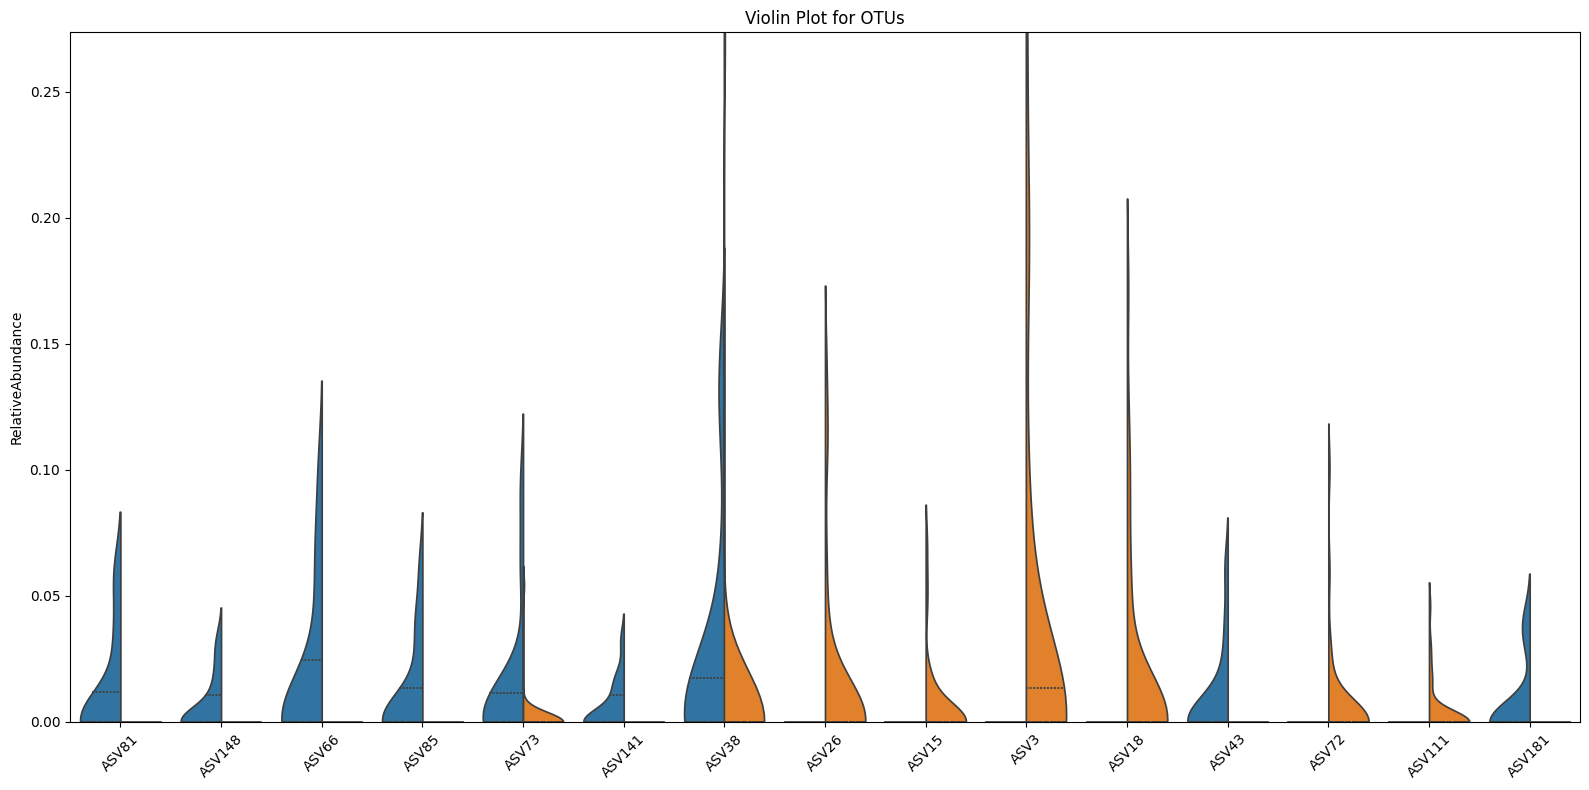

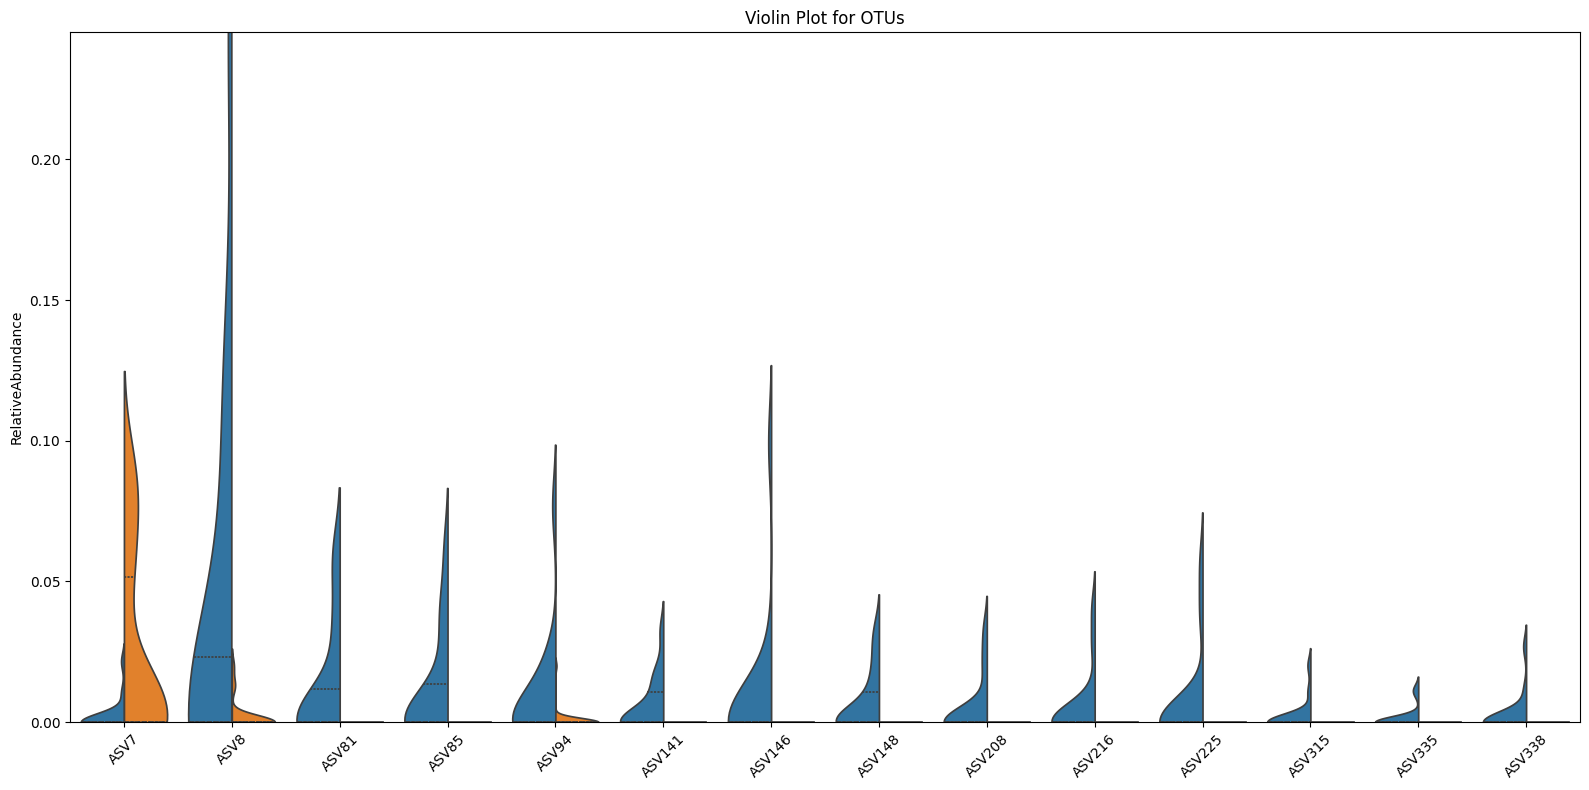

In [17]:
targetLabel=burn_label
FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15)
FS.OTUviolin(X_lassoft_list[0],targetLabel,ASVs[selectedOTU_index_lassoft_list[0]])


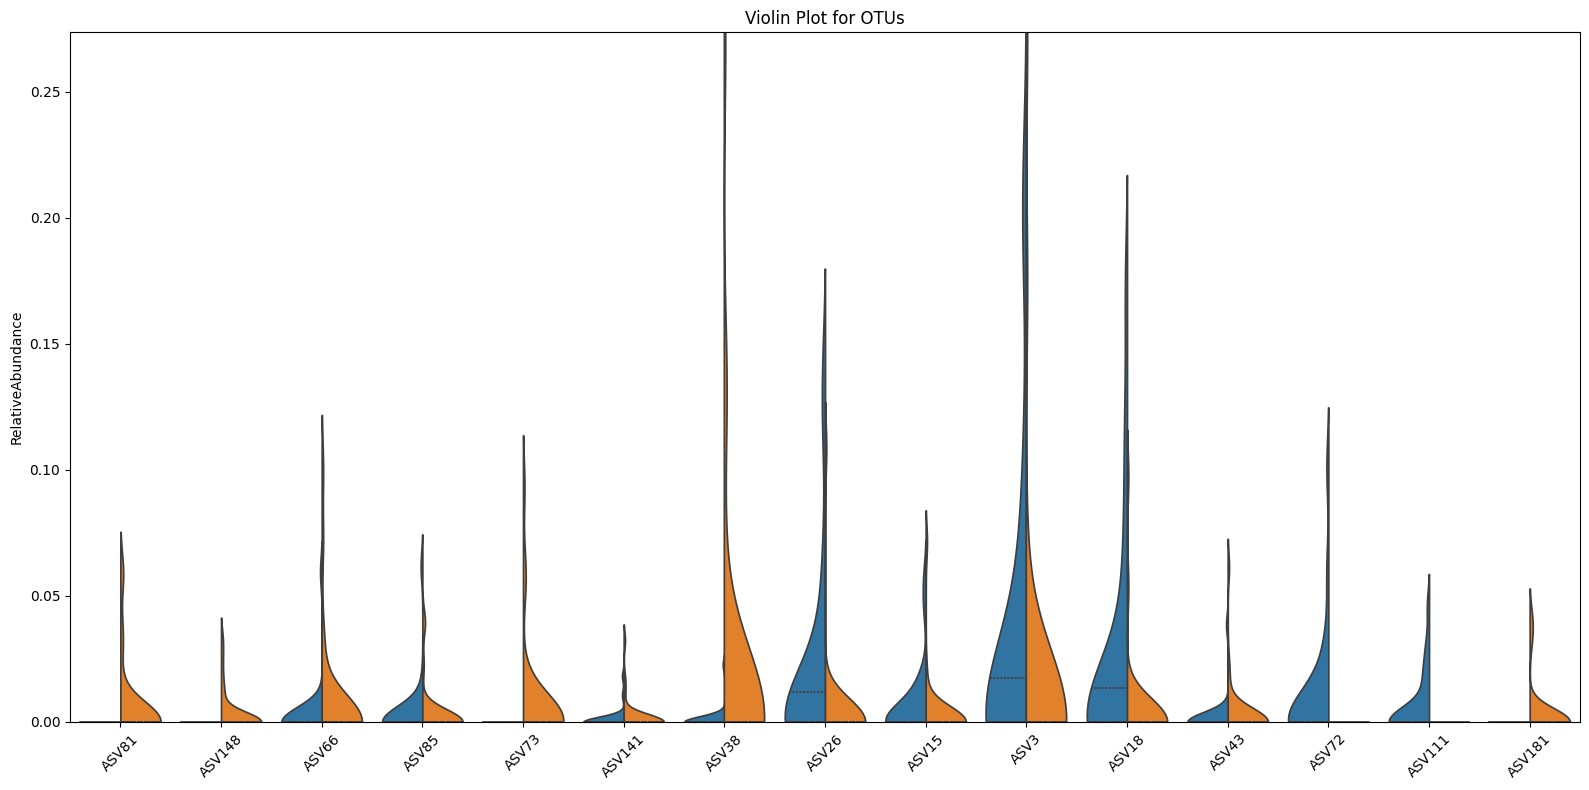

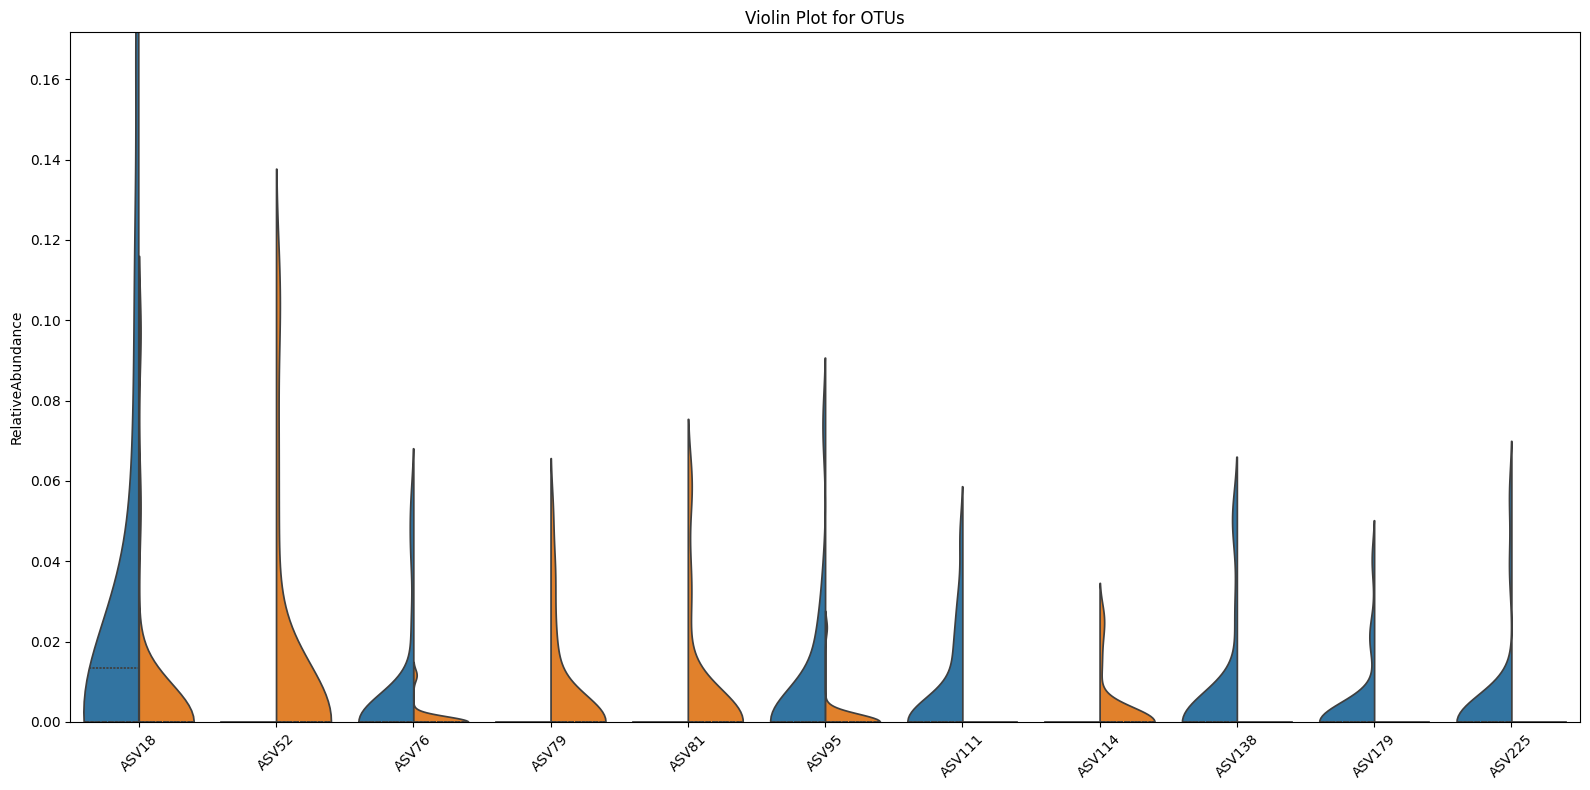

In [18]:
targetLabel=un_label
FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15)
FS.OTUviolin(X_lassoft_list[1],targetLabel,ASVs[selectedOTU_index_lassoft_list[1]])


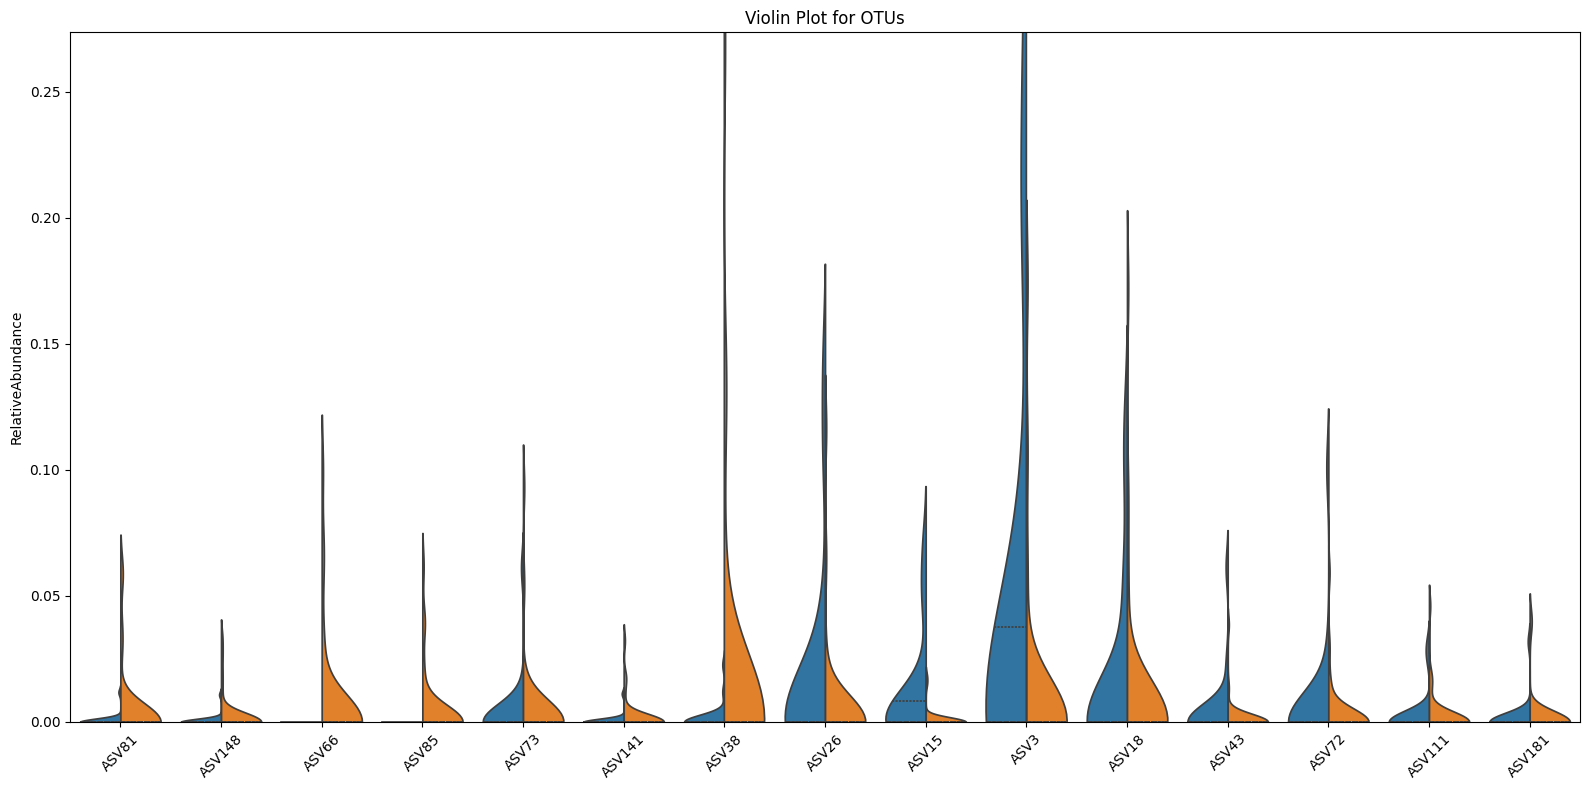

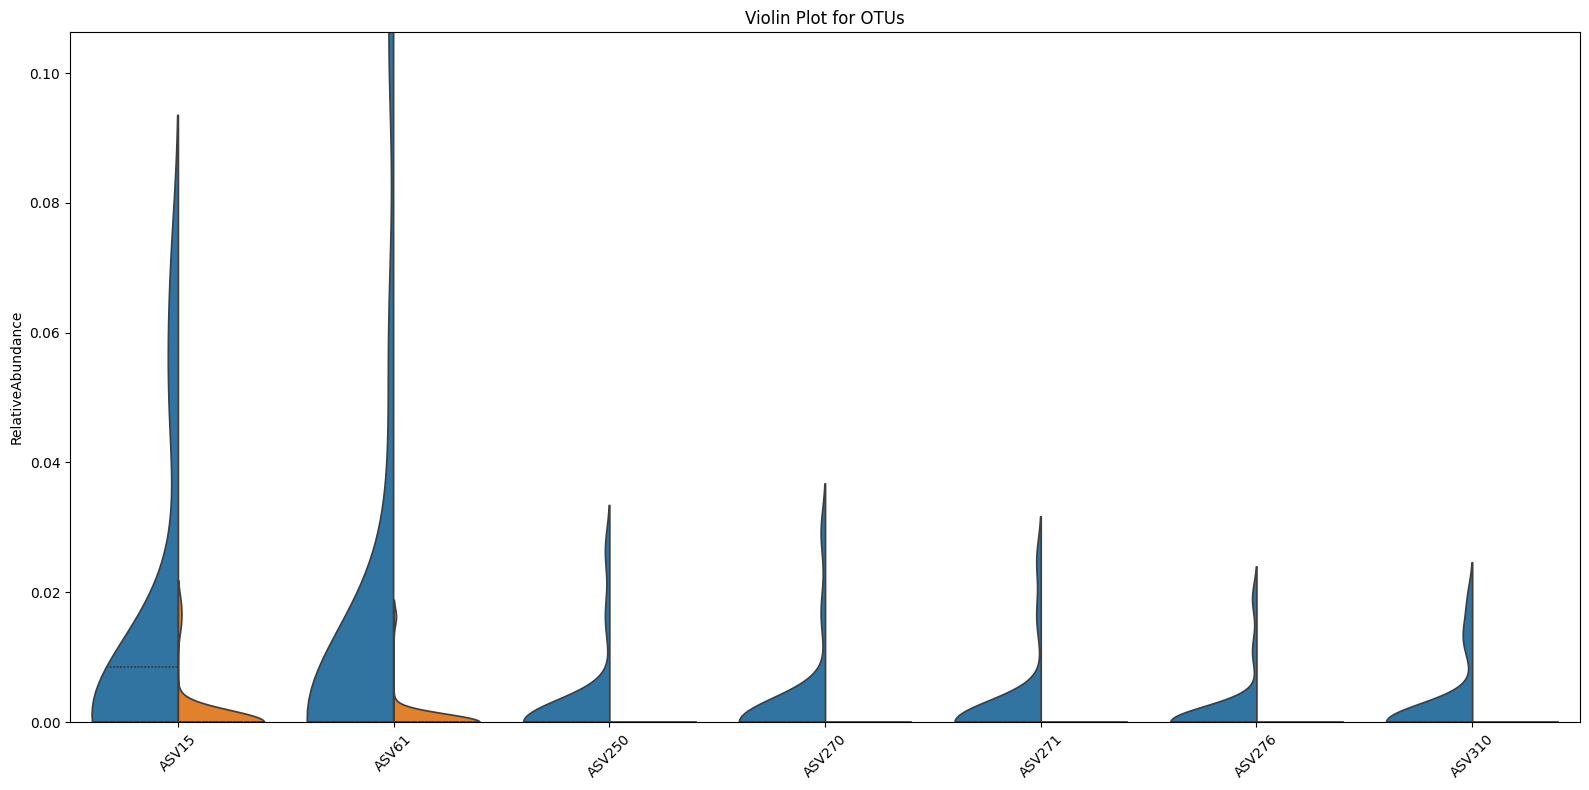

In [19]:
targetLabel=duration_label
FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15)
FS.OTUviolin(X_lassoft_list[2],targetLabel,ASVs[selectedOTU_index_lassoft_list[2]])
